# On-the-fly mapping exposure calculator (Radio astronomy)



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl

from astropy.wcs import WCS
from scipy import constants

import cygrid

np.set_printoptions(precision=1)

In [3]:
def gaincurve(elev, a0, a1, a2):
    '''
    Radio telescope sensitivity is usually a function of elevation (parametrized as parabula).
    '''
    return a0 + a1 * elev + a2 * elev * elev


def dv_to_df(restfreq, velo_kms):
    '''
    Convert velocity resolution to frequency resolution.
    '''
    return restfreq * velo_kms * 1.e3 / constants.c


def setup_header(mapcenter, mapsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
    pixsize = beamsize_fwhm / 3.
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 3,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'NAXIS3': 1,  # need dummy spectral axis
        'CTYPE1': 'RA---SIN',
        'CTYPE2': 'DEC--SIN',
        'CUNIT1': 'deg',
        'CUNIT2': 'deg',
        'CDELT1': -pixsize,
        'CDELT2': pixsize,
        'CRPIX1': (dnaxis1 + 1) / 2.,
        'CRPIX2': (dnaxis2 + 1) / 2.,
        'CRVAL1': mapcenter[0],
        'CRVAL2': mapcenter[1],
        }
    
    return header

## Introduction: Position switching
Let's start with an illustrative example, that shows how exposure calculation is done for a pointed observation (position switch). Usually, the backend provides the measured (spectral) intensities, $P$, in an uncalibrated fashion, e.g., in units of counts. Therefore one needs to derive a conversion factor. Furthermore, one has to remove the influence of the system bandpass (frequency-dependent gain). Both problems can be solved with the so-called position-switching technique:

\begin{equation}
T = T_\mathrm{sys}\frac{P_\mathrm{on} - P_\mathrm{ref}}{P_\mathrm{ref}}\,.
\end{equation}

The system temperature, $T_\mathrm{sys}$, is a property of the receiver, which determines the base noise level. It depends on the receiver noise itself, but also has conributions from ground and atmosphere, as well as astronomical background (Galactic continuum, CMB). The noise level, $\Delta T$, of the derived spectral intensity, $T$, will decrease the longer one integrates (radiometer equation):

\begin{equation}
\Delta T = \frac{T_\mathrm{sys}}{\sqrt{\tau\Delta f}}\,.
\end{equation}

However, for position switching one divides the On and Off spectra, which increases the noise by a factor of $\sqrt{2}$. This factor is absorbed by the fact, that one often has two polarization channels available, which can be averaged.

### Example: observation of NH3 lines at 23.7 GHz (at Effelsberg)
For this one would use a K-band receiver, which has about 60 K system temperature (zenith). For non-zenith observations, the airmass will increase the effective system temperature, depending on the atmospheric opacity, $\tau$.

In [4]:
dual_pol = True
restfreq = 23.7e9  # Hz
opacity = 0.07  # assume reasonably good weather
Tsys_zenith = 60.

# atmospheric temperature is approximately given by ambient temperature at ground
T_amb = 290.  # K
T_atm = T_amb - 17.

# telescope sensitivity (aka Kelvins per Jansky)
Gamma = 1.12  # K/Jy
eta_MB = 0.79  # main beam efficiency
Gamma_MB = Gamma / eta_MB

# the conversion between antenna temperatures and main-beam brightness temperatures
Ta_to_Tb = 1. / eta_MB

# spectrometer properties
nchan = 2 ** 16  # 64 k
bandwidth = 5e8  # 500 MHz
spec_reso = bandwidth / nchan * 1.16  # true spectral resolution 16% worse than channel width
print('spec_reso = {:.1f} kHz'.format(spec_reso * 1.e-3))

# desired spectral resolution
desired_vel_resolution = 1.  # km/s
desired_freq_resolution = dv_to_df(restfreq, desired_vel_resolution)
print('desired_freq_resolution = {:.1f} kHz'.format(desired_freq_resolution * 1.e-3))

# this means, we can bin the original spectrum by a factor of
smooth_nbin = int(desired_freq_resolution / spec_reso + 0.5)
# which will further decrease noise
print('smooth_nbin', smooth_nbin)


spec_reso = 8.9 kHz
desired_freq_resolution = 79.1 kHz
smooth_nbin 9


Case 1) calculate the noise after a certain integration time. The result will depend on the elevation of the source (because different airmasses modify $T_\mathrm{sys}$).

In [5]:
exposure = 60.  # seconds
elevations = np.array([10, 20, 30, 40, 50, 60, 90])
AM = 1. / np.sin(np.radians(elevations))

gain_correction = gaincurve(elevations, 0.954, 3.19E-3, -5.42E-5)

# Tsys is higher for low elevation (more air mass)
Tsys_corr = Tsys_zenith + T_atm * (np.exp(opacity * AM) - np.exp(opacity * 1))
print('Tsys_corr', Tsys_corr)
# Tsys_corr = Tsys_zenith + opacity * T_atm * (AM - 1)  # approximate formula, for small opacity * AM
# print(Tsys_corr)

# calculate Raw T_A noise
Ta_rms = Tsys_corr / np.sqrt(spec_reso * smooth_nbin * exposure)
# divide by two, for dual polarizations
if dual_pol:
    Ta_rms /= np.sqrt(2.)

# account for PSW (division by noisy reference spectrum)
Ta_rms *= np.sqrt(2.)

# convert to Raw T_B and flux-density noise:
Tb_rms = Ta_to_Tb * Ta_rms / gain_correction
S_rms = Tb_rms / Gamma_MB

Tsys_corr [ 175.7  102.2   81.2   71.6   66.3   63.2   60. ]


The astronomical signal is furthermore attenuated by the atmosphere. There are two ways to handle this. (a) If the signal strength is known (or can be expected to have a certain value), just apply the attenuation factor and compare to the noise levels. (b) calculate an effective noise level, by increasing Tb and flux-density noise accordingly. Here, we follow the second approach, as the true signal level is unknown. The effective RMS values are not true RMS estimates, but merely serve to indicate the impact of Earth's atmosphere on the sensitivity. Close to zenith, the effect is a few percent only, but for very low elevations, almost half of the signal is lost!

In [6]:
atm_atten = np.exp(-opacity * AM)

In [7]:
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    'Elev', 'Airmass', 'Tsys', 'Ta RMS', 'Tb RMS', 'S RMS', 'AtmAtten', 'Tb_eff RMS', 'S_eff RMS'
    ))
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    '[d]', '', '[K]', '[K]', '[K]', '[Jy]', '', '[K]', '[Jy]'
    ))
for idx in range(len(elevations)):
    print(
        '{0:>8.2f} {1:>8.2f} {2:>10.4f} {3:>10.4f} {4:>10.4f} '
        '{5:>10.4f} {6:>10.4f} {7:>10.4f} {8:>10.4f}'.format(
            elevations[idx], AM[idx], Tsys_corr[idx],
            Ta_rms[idx], Tb_rms[idx], S_rms[idx],
            atm_atten[idx],
            Tb_rms[idx] / atm_atten[idx], S_rms[idx] / atm_atten[idx],
            ))

print('Ta RMS = Antenna temp. noise')
print('Tb RMS = Brightness temp. noise')
print('S RMS = Flux density noise')


    Elev  Airmass       Tsys     Ta RMS     Tb RMS      S RMS   AtmAtten Tb_eff RMS  S_eff RMS
     [d]                 [K]        [K]        [K]       [Jy]                   [K]       [Jy]
   10.00     5.76   175.7436     0.0804     0.1038     0.0732     0.6682     0.1553     0.1096
   20.00     2.92   102.2078     0.0468     0.0594     0.0419     0.8149     0.0729     0.0514
   30.00     2.00    81.2300     0.0372     0.0470     0.0331     0.8694     0.0541     0.0381
   40.00     1.56    71.6143     0.0328     0.0417     0.0294     0.8968     0.0465     0.0328
   50.00     1.31    66.3269     0.0303     0.0393     0.0277     0.9127     0.0430     0.0303
   60.00     1.15    63.1879     0.0289     0.0385     0.0272     0.9224     0.0417     0.0294
   90.00     1.00    60.0000     0.0274     0.0433     0.0306     0.9324     0.0465     0.0328
Ta RMS = Antenna temp. noise
Tb RMS = Brightness temp. noise
S RMS = Flux density noise


Case 2) Now we want to calculate, how long we have to integrate, to reach a certain (effective) noise level.

In [8]:
Tb_eff_rms_desired = 0.01  # 10 mK
Ta_eff_rms_desired = Tb_eff_rms_desired * gain_correction / Ta_to_Tb

# divide by two for dual polarization
exposure = (Tsys_corr / Ta_eff_rms_desired) ** 2 / (spec_reso * smooth_nbin)
if dual_pol:
    exposure /= 2.
# account for PSW (division by noisy reference spectrum)
exposure *= 2.


In [9]:
print('Exposure time needed to reach an effective MB brightness temperature noise level of {:.1f} mK'.format(
    Tb_eff_rms_desired * 1.e3))
print('{0:>8s} {1:>10s}'.format('Elev [d]', 'Time [min]'))
for idx in range(len(elevations)):
    print('{0:>8.2f} {1:>10.1f}'.format(
        elevations[idx], (exposure / 60.)[idx]
        ))

Exposure time needed to reach an effective MB brightness temperature noise level of 10.0 mK
Elev [d] Time [min]
   10.00      107.7
   20.00       35.3
   30.00       22.1
   40.00       17.4
   50.00       15.4
   60.00       14.8
   90.00       18.8


## On-the-fly mapping
For OTF mapping, it is not straight-forward to calculate the effective noise in the map after gridding. Therefore, we simulate the process, use cygrid to produce a map, and will measure the noise accordingly.

### Map setup
In Effelsberg, we do so-called zig-zag scanning. For position switching, one observes a reference position every $n$ scanlines. In contrast to the pointed observations, it is possible to spend a different amount of time on the reference position (this will have an impact on the degree of correlated spatial noise in the final map!). 

In [10]:
map_width, map_height = 100., 100.  # arcsec
beamsize_fwhm = 38.  # arcsec; at the frequency given in our example

# the spacing between the scans should not be larger than half the beamwidth, a third is even better
num_scan_lines = int(3 * map_height / beamsize_fwhm + 0.5)
print('num_scan_lines', num_scan_lines)

# likewise, the scan velocity must not be too high; this is determined by the sampling rate
# and the beam size (one wants at least three independent samples, per beam, otherwise
# the resulting map will have some smearing along the scan lines)

# let's calculate the maximal scan speed
sampling_interval = 1.  # s (== 4 x 250 ms at Effelsberg)

max_speed = beamsize_fwhm / 3 / sampling_interval
print('max_speed = {:.2f} arcsec per s'.format(max_speed))

# with this, we can calculate the minimal duration of one scan line
min_duration = map_width / max_speed
print('min_duration = {:.1f} s'.format(min_duration))

# however, each telescope will have a duty cycle between two scan lines, which is
# defined by the time the telescope needs for re-positioning
# at Effelsberg, this is about 15 s - which means that the duration per scanline should
# at least be one or two minutes, otherwise the observing efficiency would become
# really poor

num_scan_lines 8
max_speed = 12.67 arcsec per s
min_duration = 7.9 s


In [11]:
# lets choose a meaningful scanline duration
scanline_duration = 90.  # seconds
samples_per_scanline = int(scanline_duration / sampling_interval + 0.5)
print('samples_per_scanline', samples_per_scanline)

# we now have to choose the time spent on the reference position
# furthermore, it is possible to do the reference scan only after
# every n scanlines (to save time)

# let's do a relatively long refpos integration, but only after
# every 2 scanlines (avoids some duty cycles)
refpos_duration = 90.  # seconds
refpos_interval = 2 

samples_per_scanline 90


In [12]:
# now, create the raw data
# note, the absolute value of the RMS in counts (for the P quantities) 
# is not important, but the RMS ratio between On and Ref spectra is
# (the absolute number is unimportant, because it gets calibrated away in the
# (On-Ref/Ref) equation)
# compared to the On scan, a Ref position is integrated over 'refpos_duration',
# which means that noise in the Ref spectrum is sqrt(refpos_duration / sampling_interval)
# smaller

In [13]:
# to increase the noise estimate accuracy, we will produce several noise
# maps at once
num_maps = 128

# use a dummy tsys value; the map (and RMS) can later simply be scaled to match the true tsys
dummy_tsys = 1.  

# spectral noise in arbitrary units; must be much smaller than tsys to avoid numerical problems
on_noise = dummy_tsys * 1.e-3  
ref_noise = on_noise / np.sqrt(refpos_duration / sampling_interval)

print('on_noise = {:.2e}, ref_noise = {:.2e}'.format(on_noise, ref_noise))


reduced_specs = np.empty((num_scan_lines, samples_per_scanline, num_maps))
xcoords, ycoords = np.empty((2, num_scan_lines, samples_per_scanline))
lons = np.linspace(-map_width / 2, map_width / 2, samples_per_scanline)
lats = np.linspace(-map_height / 2, map_height / 2, num_scan_lines)

for scan_line in range(num_scan_lines):
    
    if scan_line % refpos_interval == 0:
        ref_spec = np.random.normal(0., ref_noise, num_maps) + dummy_tsys
    
    on_specs = np.random.normal(0., on_noise, (samples_per_scanline, num_maps)) + dummy_tsys    
    reduced_specs[scan_line] = dummy_tsys * (on_specs - ref_spec) / ref_spec
    
    xcoords[scan_line] = lons
    ycoords[scan_line] = np.repeat(lats[scan_line], lons.size)
   

on_noise = 1.00e-03, ref_noise = 1.05e-04


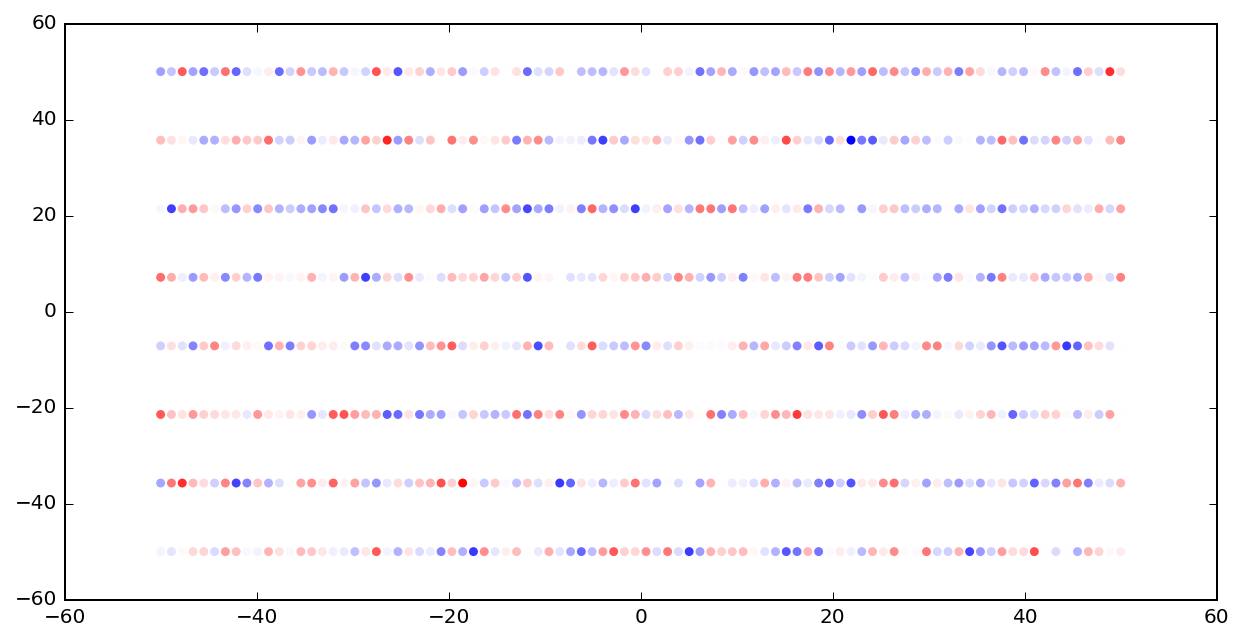

In [14]:
# testing
tmp_map = reduced_specs[..., 0]
cabs = np.max(np.abs(tmp_map))

fig = pl.figure(figsize=(10, 5))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
ax.scatter(
    xcoords, ycoords, c=tmp_map, 
    cmap='bwr', edgecolor='none',
    vmin=-cabs, vmax=cabs,
    )


In [15]:
# now do the gridding
# prepare a WCS header
target_header = setup_header((0, 0), (map_width / 3600., map_height / 3600.), beamsize_fwhm / 3600.)
target_header['NAXIS3'] = num_maps

# let's already define a WCS object for later use in our plots:
target_wcs = WCS(target_header)
print(target_header)

gridder = cygrid.WcsGrid(target_header)

kernelsize_fwhm = beamsize_fwhm / 2  
kernelsize_fwhm /= 3600.  # need to convert to degree
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
support_radius = 4. * kernelsize_sigma
healpix_reso = kernelsize_sigma / 2.

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    support_radius,
    healpix_reso,
    )

{'NAXIS1': 7, 'CDELT1': -0.0035185185185185185, 'CUNIT1': 'deg', 'CTYPE2': 'DEC--SIN', 'CRVAL1': 0, 'NAXIS3': 128, 'CRPIX1': 4.0, 'CRPIX2': 4.0, 'CDELT2': 0.0035185185185185185, 'CRVAL2': 0, 'NAXIS2': 7, 'CUNIT2': 'deg', 'NAXIS': 3, 'CTYPE1': 'RA---SIN'}


In [16]:
gridder.grid(xcoords.flatten() / 3600, ycoords.flatten() / 3600, reduced_specs.reshape((-1, num_maps)))

cygrid_cube = gridder.get_datacube()

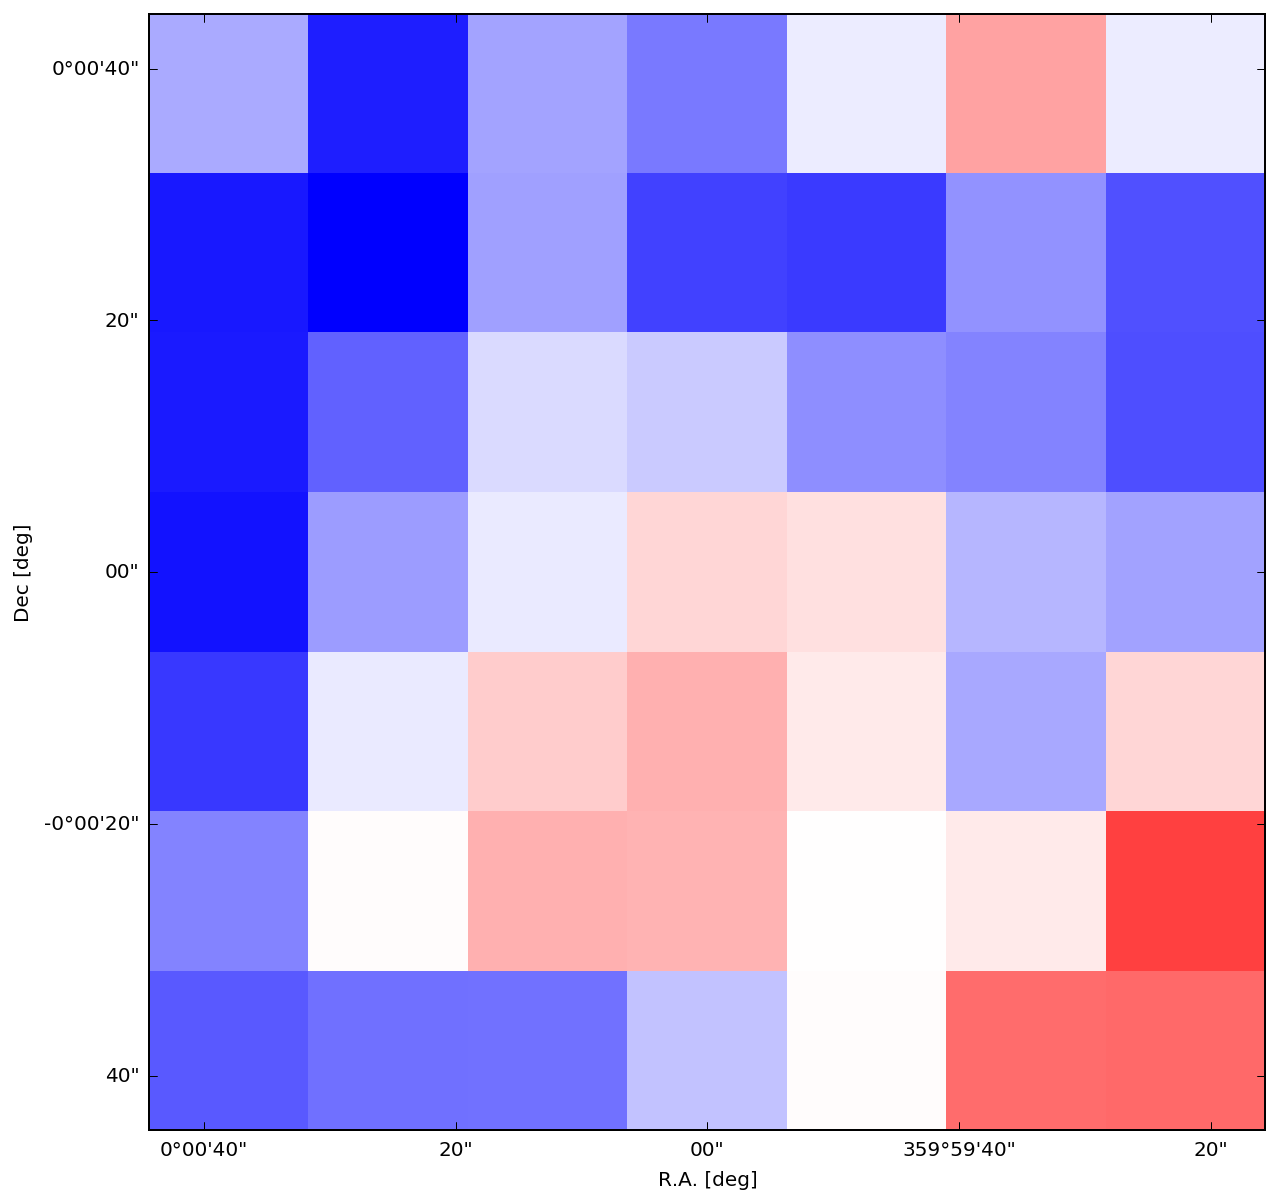

In [17]:
tmp_map = cygrid_cube[0]
cabs = np.max(np.abs(tmp_map))

fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=target_wcs.celestial)
ax.imshow(tmp_map, cmap='bwr', interpolation='nearest', origin='lower', vmin=-cabs, vmax=cabs)
lon, lat = ax.coords
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')
pl.show()

In [18]:
# measure noise
# over all cube
rms_cube = np.std(cygrid_cube, ddof=1)
# average noise per plane
rms_plane = np.mean(np.std(cygrid_cube, ddof=1, axis=(1, 2)))
print('rms_cube', rms_cube, 'rms_plane', rms_plane)

rms_cube 0.00016831 rms_plane 0.000153161


Now we can scale with Tsys, etc.

In [19]:
elevations = np.array([10, 20, 30, 40, 50, 60, 90])
AM = 1. / np.sin(np.radians(elevations))

gain_correction = gaincurve(elevations, 0.954, 3.19E-3, -5.42E-5)

# Tsys is higher for low elevation (more air mass)
Tsys_corr = Tsys_zenith + T_atm * (np.exp(opacity * AM) - np.exp(opacity * 1))
print('Tsys_corr', Tsys_corr)
# Tsys_corr = Tsys_zenith + opacity * T_atm * (AM - 1)  # approximate formula, for small opacity * AM
# print(Tsys_corr)

# T_A noise is now the measured noise from the gridded maps, times Tsys
Ta_rms = rms_cube * Tsys_corr
# divide by two, for dual polarizations
if dual_pol:
    Ta_rms /= np.sqrt(2.)

# dont' need to account for PSW (division by noisy reference spectrum) again!

# convert to Raw T_B and flux-density noise:
Tb_rms = Ta_to_Tb * Ta_rms / gain_correction
S_rms = Tb_rms / Gamma_MB

atm_atten = np.exp(-opacity * AM)

Tsys_corr [ 175.7  102.2   81.2   71.6   66.3   63.2   60. ]


In [20]:
print('-' * 95)
print('RMS per map')
print('-' * 95)
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    'Elev', 'Airmass', 'Tsys', 'Ta RMS', 'Tb RMS', 'S RMS', 'AtmAtten', 'Tb_eff RMS', 'S_eff RMS'
    ))
print('{0:>8s} {1:>8s} {2:>10s} {3:>10s} {4:>10s} {5:>10s} {6:>10s} {7:>10s} {8:>10s}'.format(
    '[d]', '', '[K]', '[K]', '[K]', '[Jy]', '', '[K]', '[Jy]'
    ))
for idx in range(len(elevations)):
    print(
        '{0:>8.2f} {1:>8.2f} {2:>10.4f} {3:>10.4f} {4:>10.4f} '
        '{5:>10.4f} {6:>10.4f} {7:>10.4f} {8:>10.4f}'.format(
            elevations[idx], AM[idx], Tsys_corr[idx],
            Ta_rms[idx], Tb_rms[idx], S_rms[idx],
            atm_atten[idx],
            Tb_rms[idx] / atm_atten[idx], S_rms[idx] / atm_atten[idx],
            ))

print('Ta RMS = Antenna temp. noise')
print('Tb RMS = Brightness temp. noise')
print('S RMS = Flux density noise')


-----------------------------------------------------------------------------------------------
RMS per map
-----------------------------------------------------------------------------------------------
    Elev  Airmass       Tsys     Ta RMS     Tb RMS      S RMS   AtmAtten Tb_eff RMS  S_eff RMS
     [d]                 [K]        [K]        [K]       [Jy]                   [K]       [Jy]
   10.00     5.76   175.7436     0.0209     0.0270     0.0190     0.6682     0.0404     0.0285
   20.00     2.92   102.2078     0.0122     0.0155     0.0109     0.8149     0.0190     0.0134
   30.00     2.00    81.2300     0.0097     0.0122     0.0086     0.8694     0.0141     0.0099
   40.00     1.56    71.6143     0.0085     0.0108     0.0076     0.8968     0.0121     0.0085
   50.00     1.31    66.3269     0.0079     0.0102     0.0072     0.9127     0.0112     0.0079
   60.00     1.15    63.1879     0.0075     0.0100     0.0071     0.9224     0.0109     0.0077
   90.00     1.00    60.0000     0.0